### Importing scraper and necessary libraries

In [20]:
from scraper import listing_df
import pandas as pd
import matplotlib.pyplot as plt
from datetime import date
import seaborn as sns
import webbrowser as wb

### Initializing Dataframe 

In [2]:
df = listing_df

### Checking and dropping NaN values if any

In [3]:
print(df.isna().sum())

prop_ID       0
rent_pw       0
suburb        0
avail_date    0
bills_inc     0
prop_pop      0
beds          0
baths         0
dtype: int64


### Describing dataset

In [4]:
df.describe()

,prop_ID,rent_pw,suburb,avail_date,bills_inc,prop_pop,beds,baths
count,252,252,252,252,252,252,252,252
unique,252,69,143,38,2,8,6,4
top,share-house-sydney-glebe-2037-P1277333,350,Randwick,Available Now,Yes,2,3,2
freq,1,23,7,159,184,58,71,123


### Checking for duplicates

In [5]:
try:
    print(pd.concat(x for _, x in df.groupby("prop_ID") if len(x) > 1))
except ValueError as err:
    print("No duplicates found!")

No duplicates found!


### Removing duplicates if any

In [6]:
df.drop_duplicates(inplace=True)

### Formatting columns to relevant types

In [7]:
 # Removing commas from the rent column
df["rent_pw"] = df["rent_pw"].replace(",","",regex=True)

# Converting beds, baths, rent_pw, prop_pop columns to int
df[["prop_pop","beds","baths","rent_pw"]] = df[["prop_pop","beds","baths","rent_pw"]].apply(pd.to_numeric)

# Removing "Available " from avail_date column
df["avail_date"] = df["avail_date"].replace("Available ","",regex=True)

# Replacing "Now" with today's date
df.loc[(df["avail_date"]=="Now"), "avail_date"] = date.today()

# Converting avail_date column to datetime data type
df["avail_date"] = pd.to_datetime(df["avail_date"]) 

### Getting property type from the `prop_ID` column

In [8]:
# Initializing a property type column from the prop_ID column
prop_type = df["prop_ID"].str.split("-sydney", n=1, expand=True)

# Setting prop_type column first array element (first split)
df["prop_type"] = prop_type[0]

# Replacing "-" with spaces to clean up column
df["prop_type"] = df["prop_type"].replace("-"," ",regex=True)

# Capitalizing column values
df["prop_type"] = df["prop_type"].str.capitalize()

### Describing dataset after converting columns to relevant data types

In [9]:
df.describe()

,rent_pw,prop_pop,beds,baths
count,252.000000,252.000000,252.000000,252.000000
mean,388.599206,2.674603,3.257937,2.059524
std,526.731236,1.768829,1.408899,0.851778
min,70.000000,0.000000,1.000000,1.000000
25%,260.000000,1.000000,2.000000,1.000000
50%,320.000000,2.000000,3.000000,2.000000
75%,410.000000,4.000000,4.000000,2.250000
max,8000.000000,7.000000,6.000000,4.000000


In [28]:
def url_creator(id):
    return f'https://flatmates.com.au/{id}'


## Checking distribution of rent values

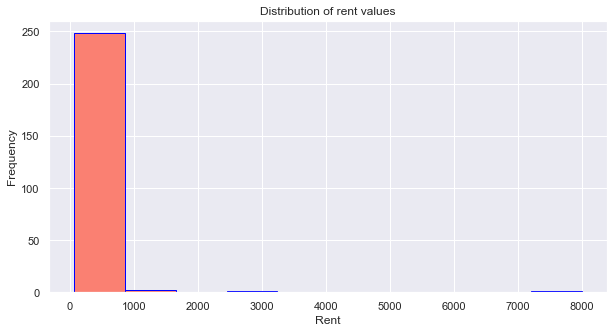

In [10]:
# Plotting frequency histogram to check distribution of rent values
sns.set(rc={"figure.figsize":(10,5)})
plt.hist(df["rent_pw"],color="salmon",edgecolor="blue")

plt.title("Distribution of rent values")
plt.xlabel("Rent")
plt.ylabel("Frequency")
plt.show()

### Heatmap to look for patterns

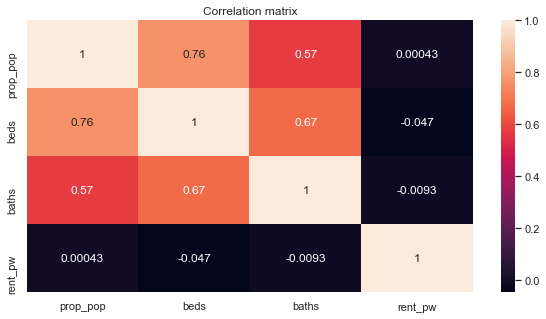

In [11]:
# Creating a view with only numerical values
numerical_data = df[["prop_pop","beds","baths","rent_pw"]]

# creating a heatmap of correlation amongst values
sns.set(rc={"figure.figsize":(10,5)}) 
sns.heatmap(numerical_data.corr(),annot=True)

plt.title("Correlation matrix")
plt.show()

##### Negative correlation amongst rent, beds and bathrooms indicates that rent does not necessarily increase with respect to number of beds and baths.

### Checking rent values

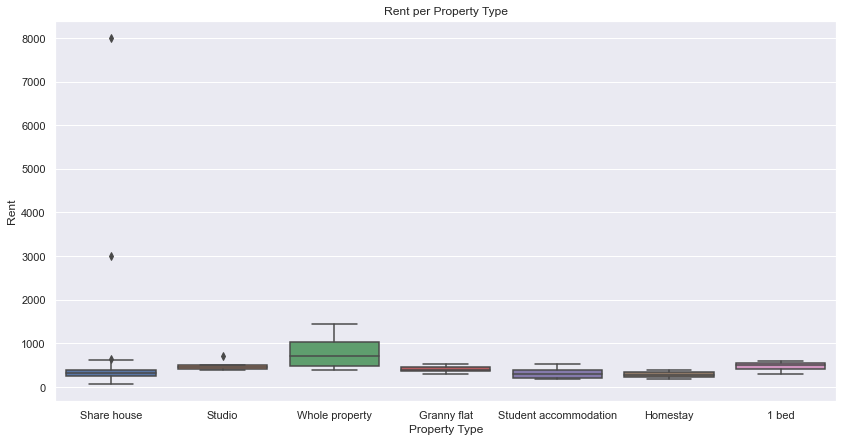

In [12]:
# Checking for more outliers by creating boxplots
sns.set(rc={"figure.figsize":(14,7)})
sns.boxplot(df['prop_type'], df["rent_pw"])
plt.xlabel("Property Type")
plt.ylabel("Rent")
plt.title("Rent per Property Type")
plt.show()

### Finding the minimum rent with bills included

In [34]:
# Creating views where bills are included in rent
view = df.loc[(df["bills_inc"] == "Yes")]

# Getting rows with minimum rent where bills are included
result = view.loc[(view["rent_pw"] == view["rent_pw"].min())]

# Getting url for the property 
url = url_creator(result['prop_ID'].values[0])
print(f"Clikc URL to view the property with the lowest rent where bills are included : \n \t{url}")

Clikc URL to view the property with the lowest rent where bills are included : 
 	https://flatmates.com.au/share-house-sydney-penrith-2750-P1133933


### Finding minimum rent where share houses have 1 bathroom per 2 people

Property population was increased by 1 to simulate the number of bathrooms available per person after one more person moves into the property. 

In [33]:
# Creating bath-to-pop ratio column (rounded to one decimal)
df["bath_to_pop_ratio"] = (df["baths"]/(df["prop_pop"]+1)).round(1)

# Getting share houses where there are atleast 1 bathroom per 2 bedrooms
view = df.loc[(df["bath_to_pop_ratio"] >= 0.5) & (df["prop_type"] == "Share house")]

# getting minimum rent where there are atleast 1 bathroom per 2 bedrooms
result = view.loc[(view["rent_pw"] == view["rent_pw"].min())]

url = url_creator(result['prop_ID'].values[0])
print(f"Click URL to view the property with the lowest rent where share houses have 1 bathroom per 2 people : \n \t{url}")

Click URL to view the property with the lowest rent where share houses have 1 bathroom per 2 people : 
 	https://flatmates.com.au/share-house-sydney-penrith-2750-P1133933


### Share houses with a population between 1 and 3

In [35]:
# Creating views to get share houses with a population in range 1 - 3 (inclusive)
view = df.loc[(df["prop_pop"] >= 1) & (df["prop_pop"] <= 3) & (df["prop_type"] == "Share house")]
result = view.loc[(view["rent_pw"] == view["rent_pw"].min())]

url = url_creator(result['prop_ID'].values[0])
print(f"Click URL to view the property with the lowest rent where share houses between 1 and 3 people: \n \t{url}")

Click URL to view the property with the lowest rent where share houses between 1 and 3 people: 
 	https://flatmates.com.au/share-house-sydney-penrith-2750-P1133933


### Median rent by property type

In [37]:
med_rent_per_prop = df.groupby(["prop_type"], as_index=False).median()
med_rent_per_prop = med_rent_per_prop[["prop_type","rent_pw"]]
med_rent_per_prop.columns = ["Prop_type","Median Rent"]
med_rent_per_prop

,Prop_type,Median Rent
0,1 bed,510.0
1,Granny flat,380.0
2,Homestay,285.0
3,Share house,315.0
4,Student accommodation,300.0
5,Studio,450.0
6,Whole property,710.0


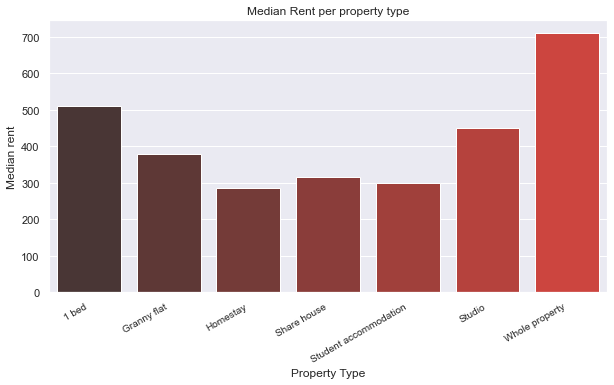

In [39]:
sns.set(rc={"figure.figsize":(10,5)})
palette = sns.color_palette("Reds_d", len(med_rent_per_prop)+6)
fig = sns.barplot(x=med_rent_per_prop['Prop_type'],y=med_rent_per_prop["Median Rent"],palette=palette)
fig.set_xticklabels(fig.get_xticklabels(),fontsize=10, rotation =30, ha="right")
plt.title("Median Rent per property type")

plt.ylabel("Median rent")
plt.show() 

### Properties available in the next 10 days

In [48]:
# Initializing empty column
df["days_to_avail"] = ""

# Converting datetime.date into datetime64 data type
today = pd.to_datetime(date.today())

# Filling column with difference of dates
df["days_to_avail"] = (df["avail_date"] - today)

# Convertin column to string
df["days_to_avail"] = df["days_to_avail"].astype("string")

# Splitting column strings to remove " days"
days = df["days_to_avail"].str.split(" ", n=1,expand=True)

# Replacing column values with numeric part
df["days_to_avail"] = days[0]

# Converting column to numeric
df["days_to_avail"] = pd.to_numeric(df["days_to_avail"])

# Initializing the number of days
days = 10

# Selecting properties that are available in the next 10 days
view = df.loc[(df["days_to_avail"] == days)]

# Printing count of available properties
print(f'{view["prop_ID"].count()} properties available in {days} days \n')

print("Click on URLs given to below to view properties available in the next 10 days \n")

for id in range(view['prop_ID'].count()):
    url = url_creator(view["prop_ID"].values[id])
    print(f'\t {id+1}. {url} \n')

11 properties available in 10 days 

Click on URLs given to below to view properties available in the next 10 days 

	 1. https://flatmates.com.au/share-house-sydney-lane-cove-north-2066-P1237034 

	 2. https://flatmates.com.au/student-accommodation-sydney-frenchs-forest-2086-P1279753 

	 3. https://flatmates.com.au/share-house-sydney-2000-P1279696 

	 4. https://flatmates.com.au/share-house-sydney-yagoona-2199-P1279604 

	 5. https://flatmates.com.au/student-accommodation-sydney-newtown-2042-P453555 

	 6. https://flatmates.com.au/student-accommodation-sydney-parramatta-2150-P1077348 

	 7. https://flatmates.com.au/student-accommodation-sydney-randwick-2031-P1077243 

	 8. https://flatmates.com.au/student-accommodation-sydney-milperra-2214-P1079356 

	 9. https://flatmates.com.au/student-accommodation-sydney-richmond-2753-P1079342 

	 10. https://flatmates.com.au/student-accommodation-sydney-marsfield-2122-P1077300 

	 11. https://flatmates.com.au/share-house-sydney-marsfield-2122-P79